---
## EDA
---

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import re
import json

In [2]:

with open('../data/da-tacos_metadata/da-tacos_benchmark_subset_metadata.json') as f:
    metadata = json.load(f)

In [3]:
print(f"Number of works: {len(metadata)}")

Number of works: 3000


In [4]:
#print the first 500 characters of the metadata
print(json.dumps(metadata, indent=4)[:500])


{
    "W_163930": {
        "P_546633": {
            "work_title": "Under Control",
            "work_artist": "Theo Hutchcraft",
            "perf_title": "Under Control",
            "perf_artist": "Beth",
            "release_year": "2016",
            "work_id": "W_163930",
            "perf_id": "P_546633",
            "instrumental": "No",
            "perf_artist_mbid": "36a50773-0a73-4cef-b5ea-532c00af50fd",
            "mb_performances": {
                "75f8d0b2-a985-4d66-95d8-4e8ce


In [5]:
h5_path = '../data/da-tacos_benchmark_subset_hpcp/W_199_hpcp/P_199_hpcp.h5'

with h5py.File(h5_path, "r") as h5f:
    if "hpcp" in h5f:
        hpcp_data = h5f["hpcp"][:]
        print("HPCP Data Shape:", hpcp_data.shape)
        print("First few values:\n", hpcp_data[:5]) 

HPCP Data Shape: (19929, 12)
First few values:
 [[0.65478104 0.296464   0.52877116 0.33990616 0.30767846 0.7123161
  0.75326556 0.949595   0.21615009 0.85385466 1.         0.3931415 ]
 [1.         0.33590442 0.52530974 0.59655434 0.8179269  0.6900676
  0.8741526  0.65152174 0.49296394 0.9832015  0.7383145  0.52369964]
 [0.50800806 0.48513496 0.59323114 0.55439264 0.36305586 0.73391175
  1.         0.70538944 0.27718443 0.9367858  0.60449857 0.6997273 ]
 [0.402746   0.27462897 0.45054498 0.4191798  0.55223113 0.44243005
  0.61511064 0.5048406  0.35272473 1.         0.40344924 0.97876793]
 [0.30902335 0.64346755 0.39050058 0.5502289  0.6752774  0.5388254
  0.5932234  0.38404614 0.2223347  1.         0.4762286  0.75401133]]


The HPCP features in this dataset have values ranging from **0 to 1**, meaning they are already normalized and do not require additional standardization. However, the **variable length** of the feature sequences (e.g., **19929 frames** in this example) may need to be addressed. To ensure consistency across samples, a common approach is to **cut longer sequences** and **pad shorter ones** to a fixed length.

In [6]:
matches = []
non_matches = []

for wid, performances in metadata.items():
    for pid, details in performances.items():
        work_title = details.get("work_title", "").strip().lower()
        perf_title = details.get("perf_title", "").strip().lower()

        if work_title == perf_title:
            matches.append((wid, pid, work_title, perf_title))
        else:
            non_matches.append((wid, pid, work_title, perf_title))

# Show some examples
print("\nExamples where the titles match:")
for wid, pid, work, perf in matches[:5]:
    print(f"WID: {wid}, PID: {pid}, Title: {work}")

print("\nExamples where the titles do NOT match:")
for wid, pid, work, perf in non_matches[:5]:
    print(f"WID: {wid}, PID: {pid}, Work Title: {work}, Performance Title: {perf}")



Examples where the titles match:
WID: W_163930, PID: P_546633, Title: under control
WID: W_173322, PID: P_609600, Title: pullman
WID: W_197587, PID: P_778616, Title: mandolin man
WID: W_71642, PID: P_469786, Title: through my sails
WID: W_68797, PID: P_85652, Title: three imaginary boys

Examples where the titles do NOT match:
WID: W_141290, PID: P_342100, Work Title: communist daughter, Performance Title: communist's daughter
WID: W_8128, PID: P_227397, Work Title: sleep, Performance Title: sleep with me
WID: W_201641, PID: P_794429, Work Title: high heels main theme, Performance Title: main theme [high heels]
WID: W_30280, PID: P_555665, Work Title: the love of a woman, Performance Title: love of a woman
WID: W_197520, PID: P_740420, Work Title: pouting, Performance Title: pouttin'


Based on the above we need to see how many work titles coresponce to the performance names

In [7]:

def clean_title(title):
    # remove anything that's not a letter or a number, then convert to lowercase
    return re.sub(r'[^a-zA-Z0-9 ]', '', title).lower()

same_title_count = 0
total_performances = 0

for wid, performances in metadata.items():
    for pid, details in performances.items():
        work_title = clean_title(details.get("work_title", ""))
        perf_title = clean_title(details.get("perf_title", ""))

        total_performances += 1
        if work_title == perf_title:
            same_title_count += 1

print(f"Total performances: {total_performances}")
print(f"Same title count (cleaned, case-sensitive): {same_title_count}")
print(f"Percentage: {same_title_count / total_performances * 100:.2f}%")


Total performances: 15000
Same title count (cleaned, case-sensitive): 13196
Percentage: 87.97%


So we can see that the 88% of the works have the same name as the performances
the other 12% as we saw above might have a similar name, or an abriviation of the original name

In [8]:
from collections import Counter

work_counts = Counter()
for wid, performances in metadata.items():
    work_counts[wid] = len(performances)

grouped_counts = Counter(work_counts.values())
print("\nNumber of works per performance count:")
for perf_count, work_count in sorted(grouped_counts.items()):
    print(f"{work_count} works have {perf_count} performances.")



Number of works per performance count:
2000 works have 1 performances.
1000 works have 13 performances.


It seems that 2/3 of the works are works with no cover songs(only one performance).
This might be from the Da-TACOS devs in order to have noice in the dataset, for better generalization of the model.

---

#### What is **Harmonic-Percussive Chroma (HPCP)?**
HPCP stands for **Harmonic-Percussive Chroma Profile**, which is a variant of chroma features that better represents **harmonic content** in music while reducing the impact of percussive (rhythmic) elements. It is used to extract **tonal information** from a signal in a way that is more robust to different playing styles and variations in instrumentation.

#### Why is HPCP better than basic Chroma features for music similarity?
1. **Separates Harmonic from Percussive Components**  
   - Standard chroma features can be influenced by drum sounds or percussive transients, which may introduce noise when analyzing **tonal** similarity.
   - HPCP specifically isolates the harmonic content, making it more reliable for comparing melodies, chords, and harmonic structures.

2. **More Robust to Timbre & Instrumentation Changes**  
   - Regular chroma features can be affected by different instrument timbres, making them less reliable for comparing pieces played with different instruments.
   - HPCP focuses on **pitch content** while reducing the impact of the instrument’s tone, improving similarity detection across different instrumentations.

3. **More Robust to Transpositions**  
   - Some implementations of HPCP include **tonal normalization** or **octave-invariant representations**, making it easier to compare two pieces of music even if they are in different keys.

4. **Better for Cover Song and Genre Similarity**  
   - Because it captures tonal characteristics more effectively, HPCP is widely used for **cover song detection**, **music recommendation**, and **genre classification**.

---

- **Y-axis (Vertical) → Pitch Classes (Octave-Collapsed, 12 Bins)**  
  - Represents the **12 pitch classes** (C, C#, D, D#, …, B), meaning that all octaves of the same note are grouped together.
  - This makes it **octave-invariant**, which is useful for comparing melodies regardless of key changes.

- **X-axis (Horizontal) → Time**  
  - Represents **time** in seconds or frames, showing how the harmonic content evolves over the duration of the track.

- **Color → Intensity (0 to 1)**  
  - The **color represents the strength (amplitude) of each pitch class** at a given moment.  
  - Values range from **0 (dark, no presence)** to **1 (bright, strong presence)**.
  - Brighter colors indicate that a particular pitch class is dominant at that time.

In [9]:
def plot_hpcp(path):
    with h5py.File(path, "r") as f:
        hpcp = np.array(f["hpcp"])
        print(f"Shape of HPCP matrix: {hpcp.shape}")
    print(f"Example HPCP matrix:\n{hpcp[:100, :100]}")

    plt.figure(figsize=(12, 6))
    plt.imshow(hpcp.T, aspect="auto", origin="lower")
    plt.xlabel("Time frame")
    plt.ylabel("HPCP bin")
    plt.title("HPCP matrix")
    plt.colorbar(label="Magnitude")
    plt.tight_layout()
    plt.show()

Shape of HPCP matrix: (41001, 12)
Example HPCP matrix:
[[0.50266254 0.267677   0.6384671  ... 0.3612551  1.         0.30714062]
 [0.49383277 0.18255335 0.25199872 ... 0.26825923 1.         0.40466657]
 [0.66735923 0.18947175 0.72625977 ... 0.4383893  1.         0.4762347 ]
 ...
 [0.6845231  0.50127375 0.94257295 ... 0.5714906  0.8179792  0.39945868]
 [0.61420673 0.3972502  0.58881754 ... 0.59922063 0.80370516 0.27316153]
 [0.48366505 0.41623443 0.31173435 ... 0.51693606 0.79139704 0.15564884]]


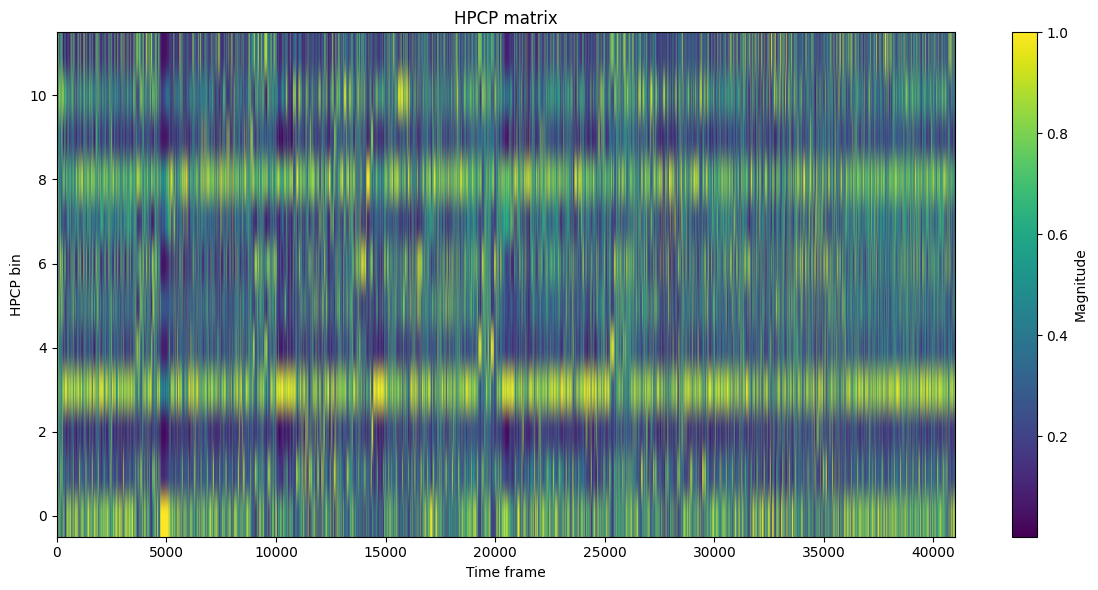

In [10]:
path = "../data/da-tacos_benchmark_subset_hpcp/W_18_hpcp/P_3849_hpcp.h5"
plot_hpcp(path)

Lets see the different length of every hcpc feature. This is crutual because our architecture(we will use CNN variant) depends on the size of the input data.

In [11]:
import os
import h5py
from collections import Counter

dataset_path = "../data/da-tacos_benchmark_subset_hpcp"

hpcp_frame_lengths = []

for wid_folder in os.listdir(dataset_path):
    wid_path = os.path.join(dataset_path, wid_folder)
    
    if os.path.isdir(wid_path):

        for file in os.listdir(wid_path):
            if file.endswith(".h5"):
                file_path = os.path.join(wid_path, file)
                try:
                    with h5py.File(file_path, "r") as h5f:
                        if "hpcp" in h5f:
                            hpcp_data = h5f["hpcp"][:]  
                            num_frames = hpcp_data.shape[0]
                            num_pitch_classes = hpcp_data.shape[1]
                            hpcp_frame_lengths.append(num_frames)
                            if num_pitch_classes != 12:
                                print(f"Unexpected number of pitch classes in {file}: {num_pitch_classes}")
                
                except Exception as e:
                    print(f"Error reading {file}: {e}")

unique_lengths = set(hpcp_frame_lengths)

print(f"\nUnique HPCP frame lengths found: {unique_lengths}")

if len(unique_lengths) == 1:
    print(f"All files have the same HPCP frame length: {unique_lengths.pop()}")
else:
    print("Files have different HPCP frame lengths!")

    length_counts = Counter(hpcp_frame_lengths)

    # print("\nHPCP frame length distribution:")
    # for length, count in sorted(length_counts.items()):
    #     print(f"{count} files have HPCP frame length {length}")



Unique HPCP frame lengths found: {32787, 32793, 32804, 32805, 32808, 32816, 32826, 32865, 32872, 32902, 32938, 32957, 32965, 32981, 32993, 32995, 32996, 33003, 33027, 33039, 33047, 33065, 33073, 33080, 33081, 33086, 33095, 33107, 33134, 33153, 33161, 33164, 33168, 33169, 33170, 33185, 33194, 33195, 33203, 33211, 33220, 33226, 33241, 33263, 33279, 33281, 33301, 33317, 33333, 33336, 33363, 33375, 33396, 33397, 33427, 33437, 33463, 33481, 33499, 33506, 33510, 33517, 33568, 33574, 33580, 33590, 33598, 33609, 33615, 33639, 33641, 33659, 33674, 33675, 33683, 33709, 33714, 33729, 33770, 33800, 33822, 33823, 33853, 33856, 33863, 33867, 33939, 33945, 33971, 33978, 33988, 33997, 34010, 34011, 34014, 34024, 34025, 34029, 34033, 34039, 34059, 34087, 34091, 34116, 34117, 34120, 34161, 34190, 34198, 34203, 34233, 34284, 34289, 34290, 34295, 34297, 34366, 34372, 34404, 34407, 34425, 34458, 34470, 34523, 34546, 34573, 34591, 34611, 34622, 34655, 34672, 34694, 34714, 34731, 34733, 34749, 34772, 34778,

In [12]:
min_length = min(hpcp_frame_lengths)
max_length = max(hpcp_frame_lengths)
mean_length = np.mean(hpcp_frame_lengths)
median_length = np.median(hpcp_frame_lengths)

print(f"Minimum HPCP frame length: {min_length}")
print(f"Maximum HPCP frame length: {max_length}")
print(f"Mean HPCP Frame Length: {mean_length}")
print(f"Median HPCP Frame Length: {median_length}")

Minimum HPCP frame length: 6225
Maximum HPCP frame length: 41285
Mean HPCP Frame Length: 18124.4562
Median HPCP Frame Length: 16684.0


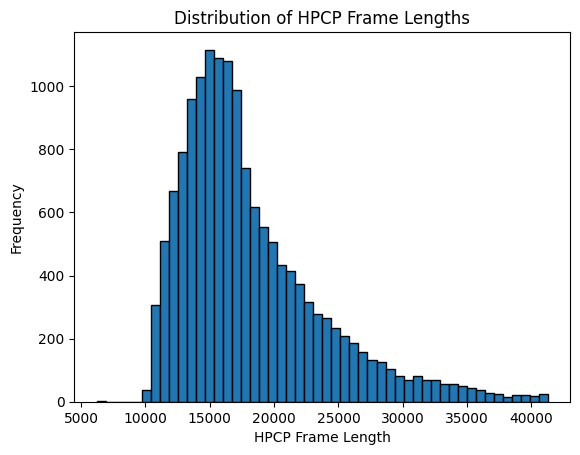

In [13]:
plt.hist(hpcp_frame_lengths, bins=50, edgecolor='black')
plt.xlabel("HPCP Frame Length")
plt.ylabel("Frequency")
plt.title("Distribution of HPCP Frame Lengths")
plt.show()

As observed in the plot above, most of the audio files have a length of **17,000 frames or less**. Therefore, a reasonable approach would be to **cut longer recordings** to 17,000 frames while **padding shorter ones** to ensure a consistent length. This standardization helps maintain uniformity across the dataset for further processing or analysis.

We can further see the code on the pipeline notebook